In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from itertools import groupby
from operator import itemgetter
import networkx as nx
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
import os
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram, optimal_leaf_ordering
from scipy.stats import mode
import warnings
import sys
sys.path.insert(0, r'..\tools')
from zscore import zscore
from smooth import smooth,ins_smooth
from color_convert import color_convert_plt
from raster_plot import raster_plot
from color_convert import color_convert_plt
from matplotlib_venn import venn3,venn2

In [2]:
path=r'.\rawdata\network_analysis'
REM_active=pd.read_excel(path+'\\REM_activeNeurons.xlsx')
REM_active_cellname=REM_active.cell_name2
is_save='no'

EM_active=pd.read_excel(path+'\\em_define.xlsx')
EM_positive=EM_active.cell_name[EM_active.rem_em==1]
EM_negative=EM_active.cell_name[EM_active.rem_em==-1]
EM_po_ne_cellname=EM_active.cell_name[EM_active.rem_em!=0]

EM_po_inREM=EM_positive[np.isin(EM_positive,REM_active_cellname)]
EM_ne_inREM=EM_negative[np.isin(EM_negative,REM_active_cellname)]
EM_po_ne_inREM=EM_po_ne_cellname[np.isin(EM_po_ne_cellname,REM_active_cellname)]

###取REM active和EM active细胞的并集
union_series = pd.concat([REM_active_cellname, EM_po_ne_cellname]).drop_duplicates().reset_index(drop=True)
print(f'REM active cell number: {len(REM_active_cellname)},number of union: {len(union_series)}')

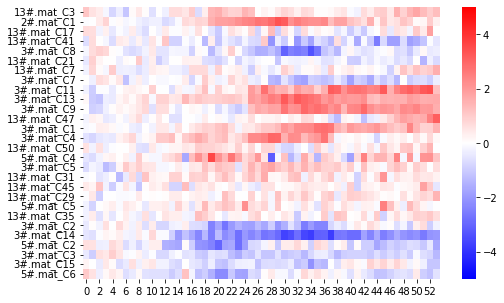

In [6]:
###读取每个细胞眼动的数据
root_EM=r'.\rawdata\out_put\Ca_acrossStage'
df=pd.read_csv(root_EM+'\\R-matrix.csv',index_col='cell_name')
df_arr=df[np.isin(df.index,EM_po_ne_cellname)]
f, ax1 = plt.subplots(figsize=(8, 5), nrows=1)
sns.heatmap(np.array(df_arr), yticklabels = df_arr.index, ax=ax1, vmax=5, vmin=-5, cmap='bwr')  ##
plt.show()

In [8]:
###计算不同REM episode持续时间下细胞响应的比例
def median(data):
    sorted_data=sorted(data)
    half = len(data) // 2
    meadia_data=(sorted_data[half]+sorted_data[half+1])/2
    return meadia_data

if __name__ == '__main__':
    path=r'.\process_data'
    new_path=r'.\rawdata\network_analysis'
    file_list=[i for i in os.listdir(path) if i.startswith('Ca')]
    cell_info=pd.read_excel(path+'\\sleep_define.xlsx',index_col=0)
    all_cell={'cell_name':[],'cell':[]}
    is_save='yes'

    print(cell_info.sleep_ID[cell_info.index])
    max_epoch=15
    ###这一段代码目前用不上
    average_Ca=pd.read_excel(path+'\\stages_average_bystates.xlsx',index_col=0)
    thre=average_Ca.apply(lambda x:median(x),axis=0)
    thre={'0':thre['wake_activity'],'5':thre['nrem_activity'],'10':thre['rem_activity']}

    for file in file_list:
        prefix=file[2:]
        ##睡眠状态
        stage=pd.read_csv(path+f'\\Stage{prefix}',sep=',').Stage
        Ca_data=pd.read_csv(path+f'\\{file}',sep=',')

        episodes= {'0':[],'5':[],'10':[]}
        wake_index=[x[0] for x in enumerate(stage) if x[1]==0]
        nrem_index=[x[0] for x in enumerate(stage) if x[1]==5]
        rem_index=[x[0] for x in enumerate(stage) if x[1]==10]

        # print(f"W_index:{wake_index}")
        for k, g in groupby(enumerate(wake_index),lambda x:x[0]-x[1]):
            group=list(map(itemgetter(1), g))
            episodes['0'].append((group[0], group[-1]+1))
        for k, g in groupby(enumerate(nrem_index),lambda x:x[0]-x[1]):
            group=list(map(itemgetter(1), g))
            episodes['5'].append((group[0], group[-1]+1))
        for k, g in groupby(enumerate(rem_index),lambda x:x[0]-x[1]):
            group=list(map(itemgetter(1), g))
            episodes['10'].append((group[0], group[-1]+1))

        ###计算状态转变的次数
        trans_number=[]
        for start, end in episodes['10'][:-1]:    ###不同转变状态需修改
            if stage[end]!=10:
                trans_number.append(end-start)

        ###按照REM持续时间排列REM起始点
        order = np.argsort(trans_number)
        grouped_id= np.array(episodes['10'])[order]

        em_fre=pd.read_csv(path+f'\\em_fre{prefix}',sep=',').em_fre.values
        em_fre=np.array(em_fre)

        em_index=pd.read_csv(path+f'\\em_index{prefix}',sep=',').em_index.values
        em_index_list=np.array(em_index).reshape((-1,512))

        valid_grouped_id,valid_trans_number=[],[]
        for start, end in grouped_id[:-1]:    ###不同转变状态需修改
            idx =[idx_i for idx_i in np.arange(start, end)]
            epoch_n=[]
            ###转变前
            for num in idx:
                if em_fre[num]!=0: ## and (len(np.where(Ca_cell[num]>thre_pos)[0])>0 or len(np.where(Ca_cell[num]<thre_neg)[0])>0)
                    epoch_n.append(1)
                else:
                    epoch_n.append(0)

            if sum(epoch_n)!=0 and 2<=len(idx)<=max_epoch and stage[end]!=10:    ###不同转变状态需修改sum(epoch_n)<len(idx)*0.5 and 2<=len(idx)<=max_epoch..
                valid_grouped_id.append([start,end])
                valid_trans_number.append(end-start)

        print(f'valid trnaistion number: {valid_trans_number}')

        ###REM duration
        unique_values, indices, counts=np.unique(trans_number,return_index=True,return_counts=True)

        for i in Ca_data.columns:                     ## Ca_data.columns:
            # print(i)

            cell_arr=[]
            Ca_cell=smooth(np.array(Ca_data[i]),11)
            mean_cell,std_cell=np.mean(Ca_cell),np.std(Ca_cell)
            thre_pos,thre_neg=mean_cell+1.96*std_cell,mean_cell-1.96*std_cell
            Ca_celli=Ca_cell.reshape((-1,64))

            valid_episode=0
            for data_ind, [start, end] in enumerate(valid_grouped_id):    ###不同转变状态需修改
                if end-start:
                    valid_episode=valid_episode+1
                    stage_data = Ca_celli[end-1:end+1].flatten()
                    cell_arr.append(stage_data)
            if valid_episode!=0:
                cell_mean=np.mean(cell_arr,axis=0)
                all_cell['cell'].append(cell_mean)
                all_cell['cell_name'].append(i)
            else:
                continue

cell_name
13#.mat_C52           R_NR
13#.mat_C51    No_response
13#.mat_C50            W_R
13#.mat_C49              R
13#.mat_C48            W_R
                  ...     
5#.mat_C3              W_R
5#.mat_C4                R
5#.mat_C5              W_R
5#.mat_C6      No_response
5#.mat_C7      No_response
Name: sleep_ID, Length: 88, dtype: object
valid trnaistion number: [2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 6, 7, 9]
valid trnaistion number: [2, 2]
valid trnaistion number: [2]
valid trnaistion number: []
valid trnaistion number: []


In [9]:
overlap=EM_po_ne_cellname[np.isin(EM_po_ne_cellname,all_cell['cell_name'])]
print(f'cell number of EM active and REM active: {len(overlap)}')
print('length of REM active: {}'.format(len(all_cell['cell_name'])))
###眼动和睡眠的长度一致，且细胞ID一致
sum_arr={'REM_name':all_cell['cell_name'], 'REM_active':all_cell['cell'], 'EM_name':all_cell['cell_name'], 'EM_active':[df.loc[i].values.tolist() for i in all_cell['cell_name']] }

###correlation matrix
ave_corr_matrix={}
ave_corr_matrix['REM_active'] = np.corrcoef(sum_arr['REM_active'], rowvar=True)
ave_corr_matrix['EM_active'] =np.corrcoef(sum_arr['EM_active'], rowvar=True)
# ave_corr_matrix['REM_active'] = cosine_similarity(sum_arr['REM_active'])
# ave_corr_matrix['EM_active'] =cosine_similarity(sum_arr['EM_active'])

REM_active_index=np.arange(len(all_cell['cell_name']))[np.isin(sum_arr['REM_name'],REM_active_cellname)]
EM_pos_index=np.arange(len(sum_arr['EM_name']))[np.isin(sum_arr['EM_name'],EM_positive)]
EM_neg_index=np.arange(len(sum_arr['EM_name']))[np.isin(sum_arr['EM_name'],EM_negative)]
EM_po_ne_index=np.arange(len(sum_arr['EM_name']))[np.isin(sum_arr['EM_name'],EM_po_ne_cellname)]
index_cellname={'REM_active':REM_active_index,'EM_active':EM_pos_index}

print (f'REM active index: {len(REM_active_index)}, {REM_active_index}')
print (f'EM positive index: {len(EM_pos_index)}, {EM_pos_index}')
print (f'EM negative index: {len(EM_neg_index)}, {EM_neg_index}')
print (f'EM active index: {len(EM_po_ne_index)}, {EM_po_ne_index}')

cell number of EM active and REM active: 24
length of REM active: 75
REM active index: 43, [ 0  2  3  4  5  6 10 11 13 14 15 16 17 21 22 24 25 27 29 31 33 34 37 38
 39 47 48 49 51 53 56 57 58 59 60 62 63 65 66 67 69 70 74]
EM positive index: 17, [ 2  5  7 17 21 23 35 45 49 51 58 60 62 64 69 70 74]
EM negative index: 7, [11 31 63 67 68 72 73]
EM active index: 24, [ 2  5  7 11 17 21 23 31 35 45 49 51 58 60 62 63 64 67 68 69 70 72 73 74]


In [10]:
np.save(new_path+'\\EM_hierarchy.dendrogram.npy',ave_corr_matrix['EM_active'])
np.save(new_path+'\\REM_hierarchy.dendrogram.npy',ave_corr_matrix['REM_active'])

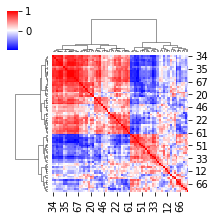

In [11]:
sns.clustermap(ave_corr_matrix['REM_active'],method='ward',metric='euclidean', figsize=(3,3), row_cluster=True,col_cluster=True,cmap="bwr")
# plt.savefig(new_path+'\\EM_hierarchy.dendrogram.pdf')
plt.show()

In [12]:
'''453
INPUT:
    matrix: an array of correlation coefficient matrix
    start: the first order
    end: the last order
RETURN:
    the cluster order which possess the maximal contrast
    the reordered matrix according to maximal contrast
    the cell index of the maximal contrast
'''
def contrast(matrix, start, end):
    correlation_matrix=matrix
    lin_clu=linkage(correlation_matrix,method='ward',metric='euclidean')

    contrast= {'order':[],'contrast':[]}

    # max_contrast,peak_index,peak_group_mat=0,np.arange(len(matrix)),matrix
    for numclu in range(start, end):
        c_node = fcluster(lin_clu, numclu, criterion='maxclust')
        order = np.argsort(c_node)
        grouped_id = c_node[order]

        ###按照新的cluster进行排序
        grouped_mat = correlation_matrix[order][:, order]

        Dall = np.sum(correlation_matrix)

        Din_sub = np.zeros(numclu)

        for iDmat in range(1, numclu+1):
            ind_subg = np.where(grouped_id == iDmat)[0]

            order_sub = order[ind_subg]

            ###计算每个cluster的CC的和
            matiD = correlation_matrix[order_sub][:, order_sub]
            Din_sub[iDmat-1] = np.sum(matiD)

        Din = np.sum(Din_sub)
        Dout = Dall - Din
        Contrast = (Din - Dout) / (Din + Dout)

        # if numclu == 2:
        #     max_contrast = Contrast
        #     peak_group_mat=grouped_mat
        #     peak_group_index=order
        #
        # else:
        #     if Contrast > max_contrast:
        #         max_contrast = Contrast
        #         peak_group_mat=grouped_mat
        #         peak_group_index=order

        contrast['order'].append(numclu)
        contrast['contrast'].append(Contrast)
    peak_num_index=np.where(contrast['contrast']==max(contrast['contrast']))[0][0]

    return contrast['order'][peak_num_index],contrast['contrast']  ##,peak_group_mat,peak_group_index

In [13]:
###提取W, NR, R统一的threshold
def thre_extract(ave_corr_matrix):
    thre_list=[]
    per=95
    contrast_item=[]
    for i in ave_corr_matrix.keys():
        matrix_i=ave_corr_matrix[i]
        np.fill_diagonal(matrix_i, 0)

        ###获得最优的层次聚类的order
        peak_numclu_i,cc_contrast=contrast(matrix_i,1,11)

        ###用上述最优的层次聚类的order进行分析
        lin_clu=linkage(matrix_i,method='ward',metric='euclidean')
        c_node = fcluster(lin_clu, peak_numclu_i, criterion='maxclust')
        print(c_node)
        order = np.argsort(c_node)
        grouped_id = c_node[order]
        print(grouped_id)

        Din_sub_val=[]
        for iDmat in range(1, peak_numclu_i+1):
            ind_subg = np.where(grouped_id == iDmat)[0]
            order_sub = order[ind_subg]
            matiD = matrix_i[order_sub][:, order_sub]
            Din_sub_val.extend(matiD.flatten())
        thre_list.extend(Din_sub_val)
        contrast_item.append(cc_contrast)
    return np.percentile(thre_list,per),contrast_item
thre,contrast_item=thre_extract(ave_corr_matrix)
thre

[2 1 1 2 2 1 2 1 2 2 1 2 2 1 1 2 1 2 1 1 1 1 1 2 1 2 2 1 1 2 1 2 1 2 1 1 1
 1 2 2 1 1 2 1 1 2 1 1 2 1 1 2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 2 1 1 1 2 1 2 2
 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
[2 2 2 1 1 2 1 2 2 1 1 1 1 2 1 1 1 2 1 2 2 2 1 2 1 1 2 2 2 1 2 1 2 1 1 2 1
 2 1 1 1 2 2 2 2 2 1 2 1 2 1 2 1 1 2 1 1 1 2 1 2 2 2 1 1 2 1 1 1 2 2 2 1 1
 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]


0.7773543534267856

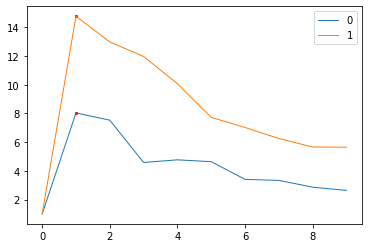

In [14]:
arr_contrast_item=np.array(contrast_item)

plt.figure(figsize=(6,4))
for i,contrast_i in enumerate(arr_contrast_item):
    peak_x=np.where(contrast_i==max(contrast_i))[0][0]
    peak_y=contrast_i[peak_x]
    plt.plot(contrast_i,lw=1,label=i);plt.legend()
    plt.scatter(peak_x,peak_y,s=5,c='r')
np.save(new_path+'\\contrast.npy', contrast_item)
# plt.savefig(new_path+'\\contrast.pdf')
plt.show()

0.7761113031456552
The threshold of 90 percentile：0.7761113031456552
the cluster which possesses the maximal averaged contrast: 1
(75,) (75, 75)


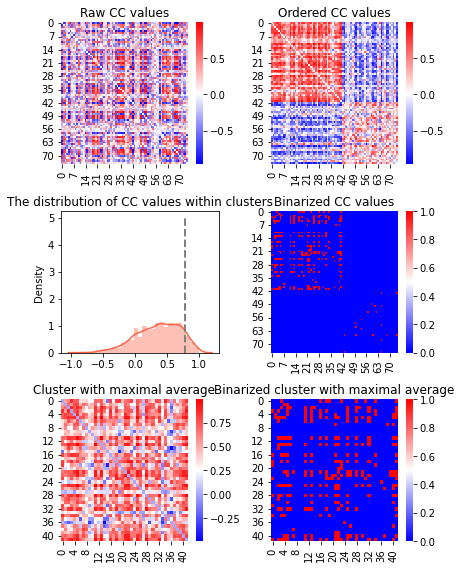

0.31637025935671315
The threshold of 90 percentile：0.31637025935671315
the cluster which possesses the maximal averaged contrast: 2
(75,) (75, 75)


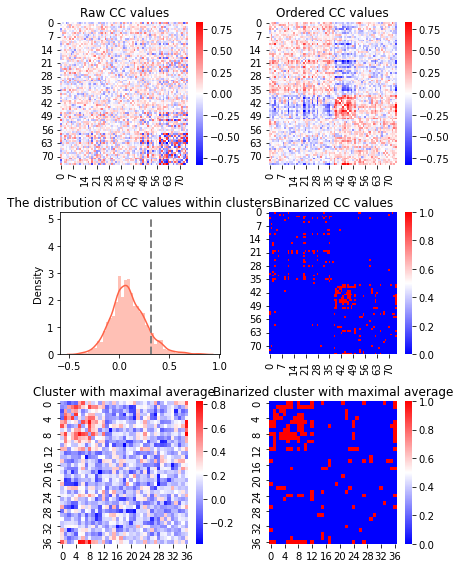

In [36]:
warnings.filterwarnings("ignore")
###寻找具有最优contrast的层次聚类order，并用该order对数据进行ensemble分析
###寻找最优oorder->确定最优clusetr->阈筛选

peak_numclu = []
binarized_optimal_clusetr_matrix,cluster_index,all_binarized_optimal,all_cluster_index={},{},{},{}
for i in ave_corr_matrix.keys():
    plt.figure(figsize=(6,8))
    matrix_i=ave_corr_matrix[i]
    np.fill_diagonal(matrix_i, 0)
    # matrix_i = np.where(matrix_i >thre[i], 1, 0)

    # matrix_i=(1-matrix_i)**2

    ###对原始的cc matrix进行作图
    plt.subplot(321)
    sns.heatmap(matrix_i,cmap='bwr');plt.title('Raw CC values')

    ###获得最优的层次聚类的order
    peak_numclu_i,cc_contrast=contrast(matrix_i,2,11)

    ###用上述最优的层次聚类的order进行分析
    lin_clu=linkage(matrix_i,method='ward',metric='euclidean')
    c_node = fcluster(lin_clu, peak_numclu_i, criterion='maxclust')
    order = np.argsort(c_node)
    grouped_id = c_node[order]
    grouped_mat = matrix_i[order][:, order]

    Din_sub = np.zeros(peak_numclu_i)

    Din_sub_val,Din_sub_val_matrix,Din_sub_val_index=[],[],[]
    for iDmat in range(1, peak_numclu_i+1):
        ind_subg = np.where(grouped_id == iDmat)[0]
        order_sub = order[ind_subg]   ###order_sub对应的就是细胞的命名编号
        matiD = matrix_i[order_sub][:, order_sub]

        Din_sub_val.extend(matiD.flatten())
        Din_sub_val_matrix.append(matiD)
        Din_sub_val_index.append(order_sub)

        Din_sub[iDmat-1] = np.sum(matiD)

    per=90
    ###每个状态单独提取阈值
    thre=np.percentile(Din_sub_val,per)
    print(thre)
    ###用三个状态统一的阈值
    # thre=thre_extract(ave_corr_matrix)

    ###填充三个状态下层次聚类的最优order
    peak_numclu.append(peak_numclu_i)

    ###对具有最大contrast的的cc matrix进行重新作图
    plt.subplot(322)
    sns.heatmap(grouped_mat,cmap='bwr');plt.title('Ordered CC values')
    ###所有位于cluster中的cc值的分布
    plt.subplot(323)
    sns.distplot(Din_sub_val,color='tomato');plt.title('The distribution of CC values within clusters')
    plt.vlines(x=thre,ymin=0,ymax=5,colors='gray',lw=2,linestyle='--')

    print(f'The threshold of {per} percentile：{thre}')
    plt.subplot(324)
    binarized_connectivity_matrix = np.where(grouped_mat >thre, 1, 0)
    sns.heatmap(binarized_connectivity_matrix,cmap='bwr');plt.title('Binarized CC values')

    ###获取具有最大均值的cluster及其对应的细胞的index
    averaged_cluster=[np.mean(cluster_i) for cluster_i in Din_sub_val_matrix]
    optimal_cluster_index=np.where(averaged_cluster==max(averaged_cluster))[0][0]

    print(f'the cluster which possesses the maximal averaged contrast: {optimal_cluster_index+1}')
    optimal_cluster=Din_sub_val_matrix[optimal_cluster_index]
    cluster_index[i]=Din_sub_val_index[optimal_cluster_index]
    ###存储所有cell
    all_cluster_index[i]=order

    plt.subplot(325)
    sns.heatmap(optimal_cluster,cmap='bwr');plt.title('Cluster with maximal average')

    plt.subplot(326)
    binarized_optimal_cluster = np.where(optimal_cluster >thre, 1, 0)
    sns.heatmap(binarized_optimal_cluster,cmap='bwr');plt.title('Binarized cluster with maximal average')

    binarized_optimal_clusetr_matrix[i]=binarized_optimal_cluster
    all_binarized_optimal[i]=binarized_connectivity_matrix

    print(all_cluster_index[i].shape,all_binarized_optimal[i].shape)

    plt.tight_layout()
    if is_save=='no':
        plt.savefig(new_path+f'\\1_workflow_{i}.pdf')

    plt.show()


[37 30 32 34 35 36 40 41 43 44 46 47 28 49 53 54 60 61 62 63 64 67 68 69
 71 50 27 74 18 16  5 10 19 13 14 20  7 22  2  1 24 21]
[37 30 32 34 35 36 40 41 43 44 46 47 28 49 53 54 60 61 62 63 64 67 68 69
 71 50 27 74 18 16  5 10 19 13 14 20  7 22  2  1 24 21  9 58  8 57 59 25
 65 66  4  3 70 72  6 56 51 11 29 31 23 33 73 38 39 42 17 45 15 48 12 26
 52 55  0]


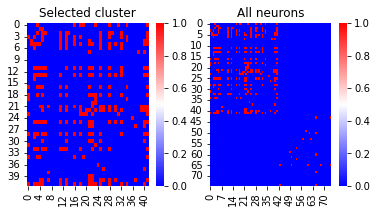

[71 51 54 65 69 58 60 61 62 70  0 37 47  1  2  5  7  8 13 17 19 20 21 49
 23 27 28 30 32 35 41 42 43 44 45 26 74]
[24 50 25 59 29 31 57 33 34 22 56 73 38 39 40 55 53 52 46 36 63 48 10 68
  9 64 11 12 67  6 14 15 16 66 18 72  3  4 71 51 54 65 69 58 60 61 62 70
  0 37 47  1  2  5  7  8 13 17 19 20 21 49 23 27 28 30 32 35 41 42 43 44
 45 26 74]


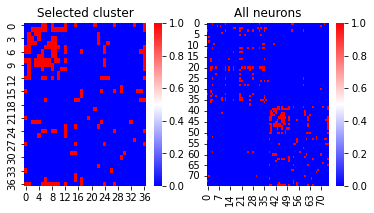

In [39]:
for stage_name,cluster_matrix in binarized_optimal_clusetr_matrix.items():
    plt.figure(figsize=(6,3))
    plt.subplot(121)
    sns.heatmap(cluster_matrix,cmap='bwr');plt.title('Selected cluster')
    print(cluster_index[stage_name])
    plt.subplot(122)
    sns.heatmap(all_binarized_optimal[stage_name],cmap='bwr');plt.title('All neurons')
    print(all_cluster_index[stage_name])
    plt.show()

REM_active中0个细胞不在总体中
selectively connected cell:28, all connected cell: 46
REM_active中0个细胞不在总体中
selectively connected cell:256, all connected cell: 286
REM_active网络匹配数据没有问题
all cellname in network ['13#.mat_C15' '13#.mat_C22' '13#.mat_C20' '13#.mat_C18' '13#.mat_C17'
 '13#.mat_C16' '13#.mat_C12' '13#.mat_C11' '13#.mat_C5' '13#.mat_C3'
 '3#.mat_C11' '3#.mat_C13' '3#.mat_C14' '3#.mat_C15' '3#.mat_C2'
 '3#.mat_C3' '3#.mat_C4' '13#.mat_C2' '13#.mat_C25' '13#.mat_C34'
 '13#.mat_C47' '13#.mat_C42' '13#.mat_C33' '13#.mat_C38' '13#.mat_C30'
 '13#.mat_C51' '13#.mat_C28' '13#.mat_C31']
cluster parameters: 0.7488343181095282, density: 0.3386243386243386, efficiency: 0.6338183421516744


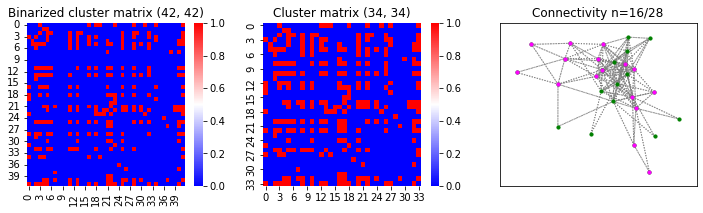

EM_active中0个细胞不在总体中
selectively connected cell:25, all connected cell: 59
EM_active中0个细胞不在总体中
selectively connected cell:150, all connected cell: 302
EM_active网络匹配数据没有问题
all cellname in network ['3#.mat_C6' '2#.mat_C1' '2#.mat_C4' '3#.mat_C16' '3#.mat_C4' '3#.mat_C1'
 '3#.mat_C11' '3#.mat_C12' '3#.mat_C13' '3#.mat_C5' '13#.mat_C52'
 '13#.mat_C15' '13#.mat_C5' '13#.mat_C47' '13#.mat_C44' '13#.mat_C32'
 '13#.mat_C31' '13#.mat_C3' '13#.mat_C29' '13#.mat_C25' '13#.mat_C22'
 '13#.mat_C17' '13#.mat_C8' '13#.mat_C26' '3#.mat_C9']
cluster parameters: 0.4671082251082251, density: 0.25, efficiency: 0.5698333333333323


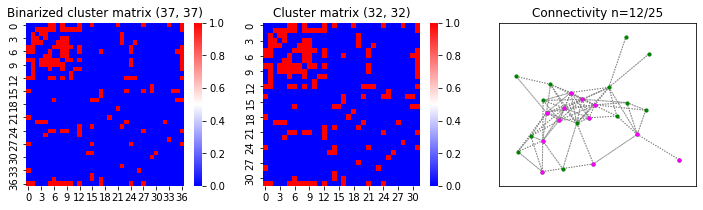

In [48]:
###绘制连接网络
valid_cell_ind,all_cell_ind={},{}
network_parameters,node_parameters={}, {}
net_graph={}
for stage_name,cluster_matrix in binarized_optimal_clusetr_matrix.items():
    plt.figure(figsize=(12,3))

    plt.subplot(131)
    # binarized_connectivity_matrix = np.where(stage_matrix >thre[stage_name], 1, 0)   ###np.percentile(similarity_matrix,99)
    sns.heatmap(cluster_matrix,cmap='bwr');plt.title(f'Binarized cluster matrix {cluster_matrix.shape}')

    plt.subplot(132)
    ### remove the isolated cell
    nonzero_valid_nodes=[i for i,arr_i in enumerate(cluster_matrix) if np.sum(arr_i)>0]
    nonzero_nodes_matrix=cluster_matrix[nonzero_valid_nodes][:,nonzero_valid_nodes]
    sns.heatmap(nonzero_nodes_matrix,cmap='bwr');plt.title(f'Cluster matrix {nonzero_nodes_matrix.shape}')

    plt.subplot(133)
    ### remove the two-isolated cell
    nonisolated_valid_nodes=[i for i,arr_i in enumerate(nonzero_nodes_matrix) if np.sum(arr_i)>1 and np.sum(nonzero_nodes_matrix[:,i])>1]
    nonisolated_nodes_matrix=nonzero_nodes_matrix[nonisolated_valid_nodes][:,nonisolated_valid_nodes]
    valid_cell_ind[stage_name]=cluster_index[stage_name][nonzero_valid_nodes][nonisolated_valid_nodes]

    mismatch_cell_index=[i for i in valid_cell_ind[stage_name] if i not in all_cluster_index[stage_name]]
    print(f'{stage_name}中{len(mismatch_cell_index)}个细胞不在总体中')

    ### 提取所有有连接的细胞
    included_nodes=[i for i,arr_i in enumerate(all_binarized_optimal[stage_name]) if np.sum(arr_i)>=1 and np.sum(all_binarized_optimal[stage_name][:,i])>=1]
    print(f'selectively connected cell:{len(nonisolated_valid_nodes)}, all connected cell: {len(included_nodes)}')
    all_nodes_matrix=all_binarized_optimal[stage_name][included_nodes][:,included_nodes]
    all_cell_ind[stage_name]=all_cluster_index[stage_name][included_nodes]

    mismatch_cell_index=[i for i in valid_cell_ind[stage_name] if i not in all_cell_ind[stage_name]]
    print(f'{stage_name}中{len(mismatch_cell_index)}个细胞不在总体中')

    # # Assuming similarity_matrices is a list of nonzero similarity matrices
    # adjacency_matrices = csr_matrix(nonisolated_nodes_matrix)
    # # Calculate clustering coefficients for each adjacency matrix
    # graph = nx.from_scipy_sparse_matrix(adjacency_matrices)
    #
    # # Draw the graph with dotted lines for functional connectivity
    # pos = nx.spring_layout(graph)

    # Get the indices of the connected nodes in the binary connectivity matrix
    connected_indices = np.argwhere(nonisolated_nodes_matrix == 1)
    edges = [(valid_cell_ind[stage_name][i], valid_cell_ind[stage_name][j]) for (i, j) in connected_indices]
    nodes=[valid_cell_ind[stage_name][i] for i,arr_i in enumerate(nonisolated_nodes_matrix)]  # if np.sum(arr_i)>0
    network_included_nodes=valid_cell_ind[stage_name][np.isin(valid_cell_ind[stage_name],index_cellname[stage_name])]# Get the indices of the connected nodes in the binary connectivity matrix
    # 获取所有细胞的网络节点
    all_connected_indices = np.argwhere(all_nodes_matrix == 1)
    all_edges = [(all_cell_ind[stage_name][i], all_cell_ind[stage_name][j]) for (i, j) in all_connected_indices]
    all_nodes=[all_cell_ind[stage_name][i] for i,arr_i in enumerate(all_nodes_matrix)]  # if np.sum(arr_i)>0
    print(f'selectively connected cell:{len(edges)}, all connected cell: {len(all_edges)}')

    graph=nx.Graph()
    graph.add_edges_from(edges)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_size=10, node_color="green")
    nx.draw_networkx_nodes(graph, pos, nodelist=network_included_nodes,node_size=10, node_color="magenta")
    nx.draw_networkx_edges(graph, pos, edgelist=edges, style='dotted',edge_color='gray')

    plt.title(f'Connectivity n={len(network_included_nodes)}/{graph.number_of_nodes()}')

    net_graph[stage_name]={'edges': edges,'nodes': nodes,'shared':network_included_nodes,'all_nodes':all_nodes, 'all_edges':all_edges}

    # ###网络分析细胞中已经label的细胞
    network_included_cellname=np.array(sum_arr[f'{stage_name[:-6]}name'])[network_included_nodes]
    if stage_name=='EM_active':
        network_map_labeld_cellname=network_included_cellname[np.isin(network_included_cellname,EM_positive)]
    if stage_name=='REM_active':
        network_map_labeld_cellname=network_included_cellname[np.isin(network_included_cellname,REM_active_cellname)]
    if len(network_map_labeld_cellname)==len(network_included_cellname):
        print(f'{stage_name}网络匹配数据没有问题')
    else:
        print(f'{stage_name}网络匹配数据存在问题')
    all_cellname_in_network=np.array(sum_arr[f'{stage_name[:-6]}name'])[valid_cell_ind[stage_name]]
    print('all cellname in network {}'.format(all_cellname_in_network))
    np.save(new_path+f'\\network_incluede_{stage_name}.npy',all_cellname_in_network)


    ### the innate properties of network
    ### Compute the average clustering coefficient for the graph
    clustering_coefficient = nx.average_clustering(graph)
    ### Compute the clustering density
    clustering_density=nx.density(graph)
    ### Returns the average local efficiency of the graph
    clustering_efficiency=nx.global_efficiency(graph)
    # ### Returns the rich-club coefficient of the graph
    # rich_club_coefficient=nx.rich_club_coefficient(graph)

    print(f'cluster parameters: {clustering_coefficient}, density: {clustering_density}, efficiency: {clustering_efficiency}')

    ### Compute the clustering coefficient for nodes
    nodes_coefficient=nx.clustering(graph)
    ave_nodes_coefficient=np.mean(list(nodes_coefficient.values()))

    ### Compute the degree centrality for nodes
    Gdegree=nx.degree_centrality(graph)  ###计算中心度-点度中心度
    ave_Gdegree=np.mean(list(Gdegree.values()))

    #中介中心性计算
    Bdegree=nx.betweenness_centrality(graph)  #返回的值是一个字典
    ave_Bdegree=np.mean(list(Bdegree.values()))
    # Bdegree=pd.DataFrame({'name':list(Bdegree.keys()),'Bdegree':list(Bdegree.values())})

    if is_save=='no':
        plt.savefig(new_path+f'\\2_workflow_{stage_name}.pdf')

    # print(list(zip(list(nodes_coefficient.values()),list(Gdegree.values()),list(Bdegree.values()))))

    network_parameters[stage_name]=[clustering_coefficient,clustering_density,clustering_efficiency,
                                    ave_nodes_coefficient, ave_Gdegree, ave_Bdegree]

    plt.show()
    # break


46 0.25139988051739515 
 28 0.3544560730219642 
 18 0.09109024773251014
59 0.28158724572593974 
 25 0.305961830734705 
 34 0.2636647567489066


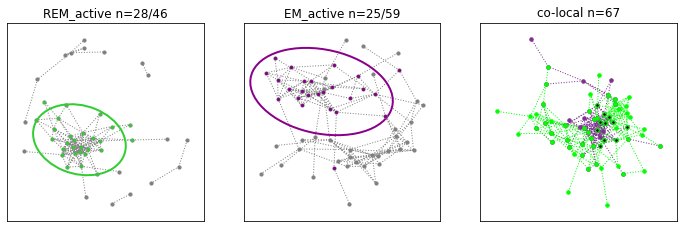

In [66]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

def plot_ellipse(mean, cov, color, scale=2):
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    max_variance_index = np.argmax(eigenvalues)
    max_eigenvector = eigenvectors[:, max_variance_index]
    angle = np.degrees(np.arctan2(max_eigenvector[1], max_eigenvector[0]))
    ellipse = Ellipse(xy=mean,
                      width=scale * 2 * np.sqrt(eigenvalues[max_variance_index]),
                      height=scale * 2 * np.sqrt(eigenvalues[1 - max_variance_index]),
                      angle=angle,
                      edgecolor=color,
                      facecolor='None',
                      linewidth=2)
    plt.gca().add_patch(ellipse)

plt.figure(figsize=(12, 8))
G = nx.Graph()

G1 = nx.Graph()
G1.add_edges_from(net_graph['REM_active']['all_edges'])

G2 = nx.Graph()
G2.add_edges_from(net_graph['EM_active']['all_edges'])

k=0.45
plt.subplot(231)
###调整K值，k 参数值越小，节点之间的距离越近，从而使布局更紧凑
pos1 = nx.spring_layout(G1, k=k)
nx.draw_networkx_nodes(G1, pos1, nodelist=G1.nodes(), node_size=10, node_color='gray')
nx.draw_networkx_nodes(G1, pos1, nodelist=net_graph['REM_active']['nodes'], node_size=5, node_color='limegreen')
nx.draw_networkx_edges(G1, pos1, edgelist=G1.edges(), style='dotted', edge_color='gray')
plt.title('REM_active n={}/{}'.format(len(net_graph['REM_active']['nodes']), G1.number_of_nodes()))
## label each node
# label1 = {node: node for node in G1.nodes()}
# nx.draw_networkx_labels(G1, pos1, labels=label1, font_size=5, font_color='black', verticalalignment='bottom')

###连接强度包括：度数中心性（degree_centrality）；接近中心性（closeness_centrality）；中介中心性（betweenness_centrality）
closeness_centrality1 = nx.closeness_centrality(G1)
shared_clos_cen1 = [closeness for node, closeness in closeness_centrality1.items() if node in net_graph['REM_active']['nodes']]
isolated_clos_cen1 = [closeness for node, closeness in closeness_centrality1.items() if node not in net_graph['REM_active']['nodes']]
print(len(closeness_centrality1), np.mean(list(closeness_centrality1.values())), '\n',
      len(shared_clos_cen1), np.mean(shared_clos_cen1), '\n',
      len(isolated_clos_cen1), np.mean(isolated_clos_cen1))

# 提取 REM_active 节点的位置
rem_active_positions = np.array([pos1[node] for node in net_graph['REM_active']['nodes']])
mean_pos_rem = np.mean(rem_active_positions, axis=0)
cov_pos_rem = np.cov(rem_active_positions, rowvar=False)
# 绘制 REM_active 节点区域的椭圆
plot_ellipse(mean_pos_rem, cov_pos_rem, 'limegreen')

plt.subplot(232)
pos2 = nx.spring_layout(G2, k=k)
nx.draw_networkx_nodes(G2, pos2, nodelist=G2.nodes(), node_size=10, node_color='gray')
nx.draw_networkx_nodes(G2, pos2, nodelist=net_graph['EM_active']['nodes'], node_size=5, node_color='darkmagenta')
nx.draw_networkx_edges(G2, pos2, edgelist=G2.edges(), style='dotted', edge_color='gray')
plt.title('EM_active n={}/{}'.format(len(net_graph['EM_active']['nodes']), G2.number_of_nodes()))
## label each node
# label2 = {node: node for node in G2.nodes()}
# nx.draw_networkx_labels(G2, pos2, labels=label2, font_size=5, font_color='black', verticalalignment='bottom')

###连接强度包括：度数中心性（degree_centrality）；接近中心性（closeness_centrality）；中介中心性（betweenness_centrality）
closeness_centrality2 = nx.closeness_centrality(G2)
shared_clos_cen2 = [closeness for node, closeness in closeness_centrality2.items() if node in net_graph['EM_active']['nodes']]
isolated_clos_cen2 = [closeness for node, closeness in closeness_centrality2.items() if node not in net_graph['EM_active']['nodes']]
print(len(closeness_centrality2), np.mean(list(closeness_centrality2.values())), '\n',
      len(shared_clos_cen2), np.mean(shared_clos_cen2), '\n',
      len(isolated_clos_cen2), np.mean(isolated_clos_cen2))

# 提取 EM_active 节点的位置
em_active_positions = np.array([pos2[node] for node in net_graph['EM_active']['nodes']])
mean_pos_em = np.mean(em_active_positions, axis=0)
cov_pos_em = np.cov(em_active_positions, rowvar=False)

# 绘制 EM_active 节点区域的椭圆
plot_ellipse(mean_pos_em, cov_pos_em, 'darkmagenta')

plt.subplot(233)
# 创建整体图形
G = nx.compose(G1, G2)
# 绘制整体图形的布局
pos = nx.spring_layout(G)

# 绘制第一个网络的节点和边
nx.draw_networkx_nodes(G1, pos, nodelist=G1.nodes(), node_size=12, node_color='#7e318e')
# nx.draw_networkx_nodes(G1, pos, nodelist=net_graph['REM_active']['shared'], node_size=4, node_color='magenta') ###color_convert_plt('#ffaf74')
nx.draw_networkx_edges(G1, pos, edgelist=G1.edges(), style='dotted', edge_color='#7e318e')

# 绘制第二个网络的节点和边
nx.draw_networkx_nodes(G2, pos, nodelist=G2.nodes(), node_size=12, node_color='#00ff00')
# nx.draw_networkx_nodes(G2, pos, nodelist=net_graph['EM_active']['shared'], node_size=4, node_color='magenta')
nx.draw_networkx_edges(G2, pos, edgelist=G2.edges(), style='dotted', edge_color='#00ff00')

shared_node = np.intersect1d(net_graph['EM_active']['nodes'], net_graph['REM_active']['nodes'])
nx.draw_networkx_nodes(G, pos, nodelist=shared_node, node_size=2, node_color='black')
plt.title('co-local n={}'.format(G.number_of_nodes()))

if is_save == 'yes':
    np.save(new_path + '\\All_net_data.npy', net_graph)
    plt.savefig(new_path + '\\All_neurons_network.pdf')

plt.show()

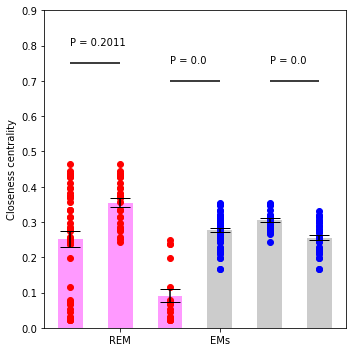

In [69]:
from t_test import t_test

plt.figure(figsize=(5,5))
isolated_clos_cen2.remove(max(isolated_clos_cen2))

net_REM=np.concatenate((shared_clos_cen1,isolated_clos_cen1))
net_EM=np.concatenate((shared_clos_cen2,isolated_clos_cen2))

_avg = [np.mean(net_REM),np.mean(shared_clos_cen1),np.mean(isolated_clos_cen1),np.mean(net_EM),np.mean(shared_clos_cen2),np.mean(isolated_clos_cen2)]

_err1 = np.std(net_REM)/np.sqrt(len(net_REM))
_err2 = np.std(shared_clos_cen1)/np.sqrt(len(shared_clos_cen1))
_err3 = np.std(isolated_clos_cen1)/np.sqrt(len(isolated_clos_cen1))
_err4 = np.std(net_EM)/np.sqrt(len(net_EM))
_err5 = np.std(shared_clos_cen2)/np.sqrt(len(shared_clos_cen2))
_err6 = np.std(isolated_clos_cen2)/np.sqrt(len(isolated_clos_cen2))
_err=[_err1,_err2,_err3,_err4,_err5,_err6]

_,p0=t_test(net_REM,net_EM)
_,p1=t_test(shared_clos_cen1,isolated_clos_cen1)
_,p2=t_test(shared_clos_cen2,isolated_clos_cen2)

colors=['magenta','magenta','magenta','gray','gray','gray']
plt.bar([1,2,3,4,5,6],_avg, width=0.5, color=colors, alpha=0.4)

for item in net_REM:
    plt.plot(1, item, 'ro')
for item in shared_clos_cen1:
    plt.plot(2, item, 'ro')
for item in isolated_clos_cen1:
    plt.plot(3, item, 'ro')
for item in net_EM:
    plt.plot(4, item, 'bo')
for item in shared_clos_cen2:
    plt.plot(5, item, 'bo')
for item in isolated_clos_cen2:
    plt.plot(6, item, 'bo')
plt.errorbar([1,2,3,4,5,6][0],_avg[0], yerr=_err[0], capsize=10, color='k')
plt.errorbar([1,2,3,4,5,6][1],_avg[1], yerr=_err[1], capsize=10, color='k')
plt.errorbar([1,2,3,4,5,6][2],_avg[2], yerr=_err[2], capsize=10, color='k')
plt.errorbar([1,2,3,4,5,6][3],_avg[3], yerr=_err[3], capsize=10, color='k')
plt.errorbar([1,2,3,4,5,6][4],_avg[4], yerr=_err[4], capsize=10, color='k')
plt.errorbar([1,2,3,4,5,6][5],_avg[5], yerr=_err[5], capsize=10, color='k')

plt.hlines(0.75, 1, 2, 'k');plt.text(1, 0.8, f'P = {np.round(p0,4)}')
plt.hlines(0.7, 3, 4, 'k');plt.text(3, 0.75, f'P = {np.round(p1,4)}')
plt.hlines(0.7, 5, 6, 'k');plt.text(5, 0.75, f'P = {np.round(p2,4)}')

plt.ylabel("Closeness centrality")
plt.xticks([2,4],['REM','EMs']);plt.ylim(0,0.9)
plt.tight_layout()

para_network=pd.DataFrame([shared_clos_cen1,isolated_clos_cen1,shared_clos_cen2,isolated_clos_cen2]).T
para_network.columns=['shared_clos_cen1','isolated_clos_cen1','shared_clos_cen2','isolated_clos_cen2']

if is_save=='yes':
    para_network.to_excel(new_path+'\\closeness_centrality2.xlsx',index=None)
    plt.savefig(new_path+'\\connectivity strength2.pdf')

plt.show()

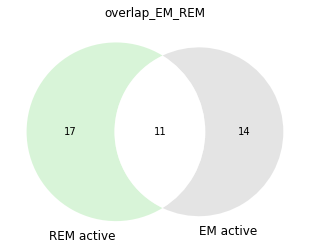

In [15]:
venn2(subsets=(17,14, 11), set_labels=('REM active', 'EM active'),set_colors=(color_convert_plt('#bfeebe'),color_convert_plt('#d3d3d3')),alpha=0.6,normalize_to=1.0)
plt.title('overlap_EM_REM')
plt.savefig(new_path + '\\overlap_node.pdf')
plt.show()